# Resolved Sideband Cooling


## Atomic Circuit


In [54]:
import numpy as np
from oqd_core.interface.atomic import (
    AtomicCircuit,
    Beam,
    Ion,
    Level,
    ParallelProtocol,  # noqa: F401
    Phonon,
    Pulse,
    SequentialProtocol,  # noqa: F401
    System,
    Transition,
)

downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
    label="q0",
)
upstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 12.643e3,
    label="q1",
)
estate = Level(
    principal=6,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 811.29e6,
    label="e0",
)

transitions = [
    Transition(
        level1=downstate, level2=estate, einsteinA=1, multipole="E1", label="q0->e0"
    ),
    Transition(
        level1=upstate, level2=estate, einsteinA=1, multipole="E1", label="q1->e0"
    ),
]

Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 0],
    levels=[downstate, upstate, estate],
    transitions=transitions,
)

COM_x = Phonon(energy=2 * np.pi * 1, eigenvector=[1, 0, 0])

system = System(
    ions=[Yb171],
    modes=[COM_x],
)

beam = Beam(
    transition=transitions[1],
    rabi=2 * np.pi * 1e4,
    detuning=-2 * np.pi * 1,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)


protocol = ParallelProtocol(
    sequence=[
        Pulse(beam=beam, duration=1e-3),
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [55]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("1a_optical_pumping.json", "w") as f:
    f.write(circuit_json)

In [56]:
with open("1a_optical_pumping.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


### Compile


In [57]:
from oqd_compiler_infrastructure import Chain, Post

from oqd_trical.backend import DynamiqsBackend, QutipBackend  # noqa: F401
from oqd_trical.light_matter.compiler.approximate import (
    RotatingReferenceFrame,
    RotatingWaveApprox,
)
from oqd_trical.light_matter.compiler.canonicalize import (
    canonicalize_emulator_circuit_factory,
)
from oqd_trical.light_matter.compiler.codegen import InjectDissipation
from oqd_trical.light_matter.interface import ConstantCoefficient, Identity, KetBra

frame_specs = {
    "E0": [0, 2 * np.pi * 12.643e3, 2 * np.pi * 811.29e6],
    "P0": 2 * np.pi * 1,
}

dissipation = [
    ConstantCoefficient(2 * np.pi * 1e2)
    * KetBra(ket=0, bra=2, subsystem="E0")
    @ Identity(subsystem="P0"),
    ConstantCoefficient(2 * np.pi * 1e2)
    * KetBra(ket=1, bra=2, subsystem="E0")
    @ Identity(subsystem="P0"),
]

approx_pass = Chain(
    Post(RotatingReferenceFrame(frame_specs=frame_specs)),
    canonicalize_emulator_circuit_factory(),
    Post(RotatingWaveApprox(cutoff=2 * np.pi * 1e3)),
    Post(InjectDissipation(dissipation=dissipation)),
)

backend = QutipBackend(approx_pass=approx_pass, solver="MESolver")

fock_cutoff = 3
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

class_='AtomicEmulatorGate' hamiltonian=OperatorAdd(class_='OperatorAdd', op1=OperatorScalarMul(class_='OperatorScalarMul', op=OperatorKron(class_='OperatorKron', op1=KetBra(class_='KetBra', subsystem='E0', ket=2, bra=1), op2=Displacement(class_='Displacement', subsystem='P0', alpha=WaveCoefficient(class_='WaveCoefficient', amplitude=MathNum(class_='MathNum', value=9.243555729064034e-05), frequency=MathNum(class_='MathNum', value=6.283185307179586), phase=MathNum(class_='MathNum', value=1.5707963267948966)))), coeff=WaveCoefficient(class_='WaveCoefficient', amplitude=MathNum(class_='MathNum', value=31415.926535897932), frequency=MathNum(class_='MathNum', value=6.283185005187988), phase=MathNum(class_='MathNum', value=0))), op2=OperatorScalarMul(class_='OperatorScalarMul', op=OperatorKron(class_='OperatorKron', op1=KetBra(class_='KetBra', subsystem='E0', ket=1, bra=2), op2=Displacement(class_='Displacement', subsystem='P0', alpha=WaveCoefficient(class_='WaveCoefficient', amplitude=MathN

In [58]:
from oqd_trical.light_matter.compiler.visualization import CondensedOperatorPrettyPrint

printer = Post(CondensedOperatorPrettyPrint())

print(printer(hilbert_space), "=" * 80, printer(backend.intermediate), sep="\n")

HilbertSpace
  - hilbert_space: dict
    - E0: set({0, 1, 2})
    - P0: set({0, 1, 2})
AtomicEmulatorCircuit
  - frame: Operator(79438.3118386715 * |1><1|_E0 @ I_P0 + 5097485407.861727 * |2><2|_E0 @ I_P0 + 6.283185307179586 * I_E0 @ C_P0 * A_P0)
  - sequence: list
    - 0: AtomicEmulatorGate
      - hamiltonian: Operator(31415.926535897932 * exp(1j * (6.283185005187988 * t)) * |2><1|_E0 @ D(9.243555729064034e-05 * exp(1j * (6.283185307179586 * t + 1.5707963267948966)))_P0 + 31415.926535897932 * exp(1j * (-6.283185005187988 * t)) * |1><2|_E0 @ D(9.243555729064034e-05 * exp(1j * (6.283185307179586 * t + -1.5707963267948966)))_P0)
      - dissipation: list
        - 0: Operator(628.3185307179587 * |0><2|_E0 @ I_P0)
        - 1: Operator(628.3185307179587 * |1><2|_E0 @ I_P0)
      - duration: float(0.001)


### Run


In [59]:
import qutip as qt

result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-5,
    initial_state=qt.tensor(qt.basis(3, 1), qt.basis(fock_cutoff, 0)),
)

10.0%. Run time:   0.70s. Est. time left: 00:00:00:06
20.0%. Run time:   1.26s. Est. time left: 00:00:00:05
30.0%. Run time:   1.89s. Est. time left: 00:00:00:04
40.0%. Run time:   2.48s. Est. time left: 00:00:00:03
50.0%. Run time:   3.05s. Est. time left: 00:00:00:03
60.0%. Run time:   3.68s. Est. time left: 00:00:00:02
70.0%. Run time:   4.26s. Est. time left: 00:00:00:01
80.0%. Run time:   4.88s. Est. time left: 00:00:00:01
90.0%. Run time:   5.37s. Est. time left: 00:00:00:00
100.0%. Run time:   5.92s. Est. time left: 00:00:00:00
Total run time:   5.92s


#### Results


In [60]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

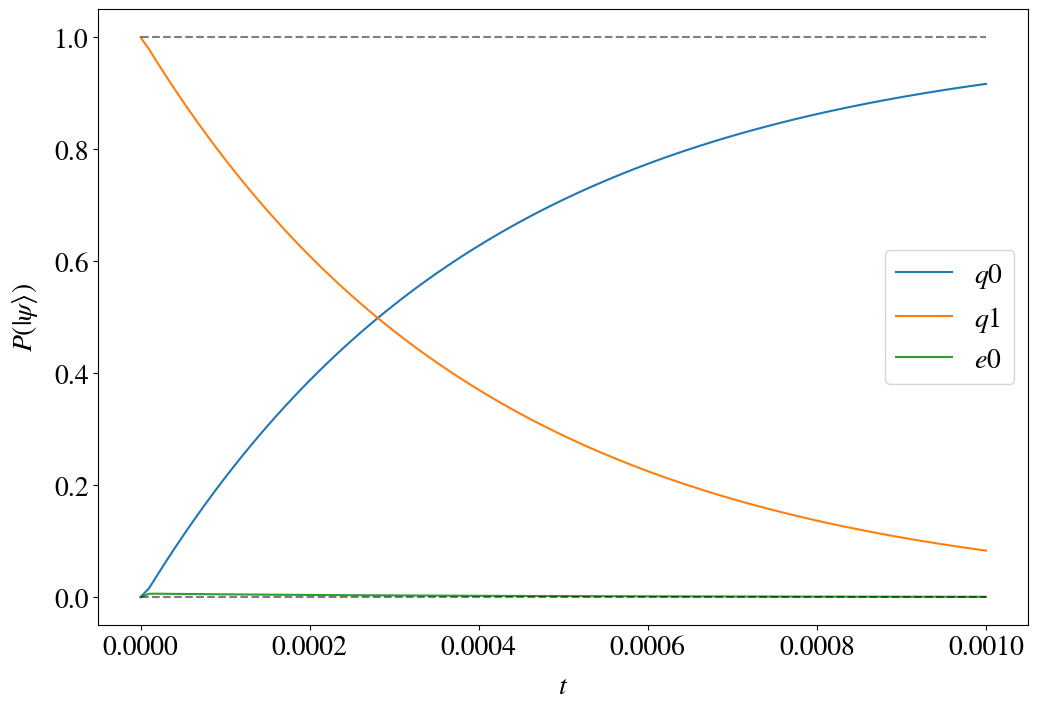

In [61]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(0).diag()[:] for s in result["states"][k]],
    label=[rf"${level.label}$" for level in Yb171.levels],
)
ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

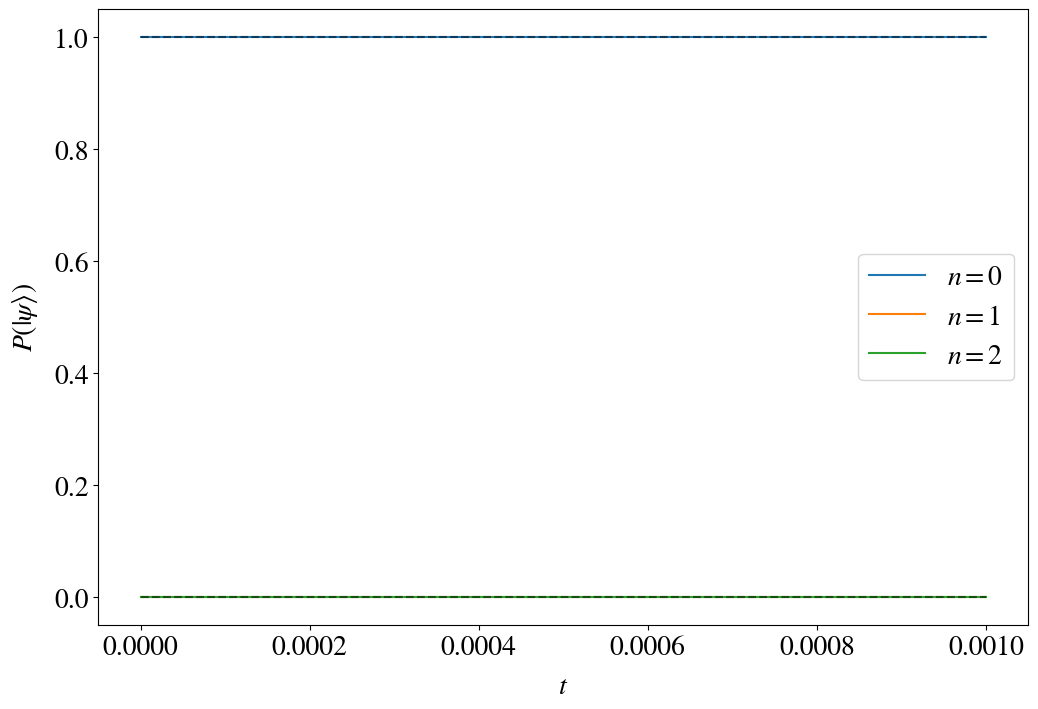

In [62]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(1).diag()[:] for s in result["states"][k]],
    label=[rf"$n={n}$" for n in range(fock_cutoff)],
)
ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()